In [1]:
%matplotlib inline
from IPython.display import display
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

pd.set_option('max_rows', 10)
pd.set_option('max_columns', 10)

## ケーススタディ
---
顧客(消費者)の購買データ分析担当者として、以下の問題を考える。

- **何を**分析したいか(**何が**知りたいか)
- その分析を実行するためには**どのようなデータが必要**そうか

## 前提知識

### 条件付き確率
---
下図で $A,B$ の占める領域を $\sigma ( A),\sigma ( B)$ 、全体を $\sigma ( U)$ とすると、 $A,B$ が発生する確率 $p( A),p( B)$ は、

$
\displaystyle p( A) =\frac
    {\sigma ( A)}
    {\sigma ( U)}
,p( B) =\frac
    {\sigma ( B)}
    {\sigma ( U)}
$

のように表せる。

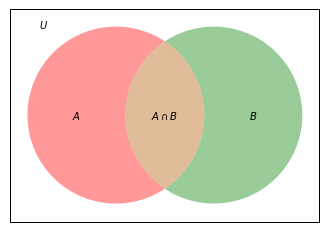

In [2]:
from helpers.market_basket_analysis import venn
venn.show()

$A,B$ が同時に発生する場合は上図の $A,B$ が重なる領域 $A\cap B$ であり、 $A,B$ が同時に発生する確率 $p( A,B)$ は

$
\displaystyle p( A,B) =\frac
    {\sigma ( A\cap B)}
    {\sigma ( U)}
$

と表せる。

$A$ が発生した ($A$ という条件が与えられた、あるいは領域 $A$ を領域 $U$ の代わりに全体とする) 場合の $B$ が発生する確率を $p( B|A)$ と表現する。上の図では $p( B|A)$ は $A$ の領域に含まれる $B$ の領域の割合、つまり

$
\displaystyle p( B|A) =\frac
    {p( A,B)}
    {p( A)}
$

例えば、野球の得点圏打率は走者が2~3塁にいるという条件 ($A$) のもとでのヒットを打つ ($B$) という条件つき確率

### 参考
---
以下は、わからなければ最初はスルーして良い。

#### ベイズの定理 (Bayes' theorem)
---
ある事象が観測されたときの、別の事象に関する確率を求める。

$
{\displaystyle p( B|A) =\frac
    {p( A|B)\cdot p( B)}
    {p( A)}
}
$

##### 具体例
---
2つの袋に赤・白2種類の玉が以下のように入っているところを考える。

<table class="background-bright text-center border">
    <tr class="background-dark">
        <th class="border-right-bold"></th>
        <th>赤玉</th>
        <th>白玉</th>
    </tr>
    <tr>
        <th class="background-dark border-bottom border-right-bold">袋1</th>
        <td>3</td>
        <td>7</td>
    </tr>
    <tr>
        <th class="background-dark border-bottom border-right-bold">袋2</th>
        <td>6</td>
        <td>4</td>
    </tr>
</table>

ここで片方の袋 (外見からはどちらかわからない) を選んで、玉を1個取り出す。袋1を選ぶ確率を $P( A) =0.5$ 、赤玉を選ぶ確率を $P( B) =( 3+6) \div 20=0.45$ とする。 (袋2を選ぶ確率は $1-P( A) =0.5$ 、白玉を選ぶ確率は $1-P( B) =0.55$)

このとき、

袋1を選んだときにそれが赤玉である確率 $P( B|A) =3\div ( 3+7) =0.3$

赤玉を選んだときにそれが入っていたのが袋1である確率 $P( A|B) =3\div ( 3+6) \fallingdotseq 0.333\dotsc $

と表せる。

袋1を選ぶ確率 $P( A)$ が変化した場合は、表の上段に $P( A)$ 、下段に $1-P( A)$ を掛けて、同様に求められるが、ベイズの定理を使うと、

赤玉を選んだときにそれが入っていたのが袋1である確率 $
{\displaystyle P( A|B) =\frac
    {P( B|A)\cdot P( A)}
    {P( B)}
}
$ のように求められる。

ベイズの定理 $
{\displaystyle p( B|A) =\frac
    {p( A|B)\cdot p( B)}
    {p( A)}
}
$ で、 $A$ という事象が観測される前の確率 $p( B)$ を事前確率、 $A$ という事象を観測した後の確率 $p( B|A)$ を事後確率という。

###### 練習問題

問診の結果から、 X さんがある病気である確率が $5\%$ だと判明した。そこで血液検査を行ったところ、病気 (陽性) であるという結果が出た。この血液検査では、実際に病気である場合に陽性と判定される確率は $70\%$ である。血液検査の結果、 X さんが病気である確率は何 $\%$ になったか求めてみる。ただし、病気の有無に関係なく一般にこの検査を実施した場合にこの血液検査で病気 (陽性) という判定が出る確率は $4\%$ とする。

血液検査の前に X さんが病気である確率は $P( A) =0.05$

一般に (無作為に) 血液検査を行って病気という判定が出る確率は $P( B) =0.04$

病気である場合に血液検査で病気という判定が出る確率は $P( B|A) =0.7$

血液検査で病気という判定が出た後の X さんが病気である確率は

$
\begin{align}
    P( A|B) & ={\displaystyle \frac
        {P( B|A)\cdot P( A)}
        {P( B)}
    }\\
     & \\
     & =\frac
         {0.7\cdot 0.05}
         {0.04}\\
     & \\
     & =0.875
\end{align}
$

## マーケット・バスケット分析 (アソシエーション分析)
---
条件付き確率を使って、**よく一緒に買われる**商品を見つけるための手法。

## 対象となるデータ
---
トランザクションデータ (商品A・B・Cが一緒に買われた、ページA・B・Cが同時に閲覧されたなど) が対象。

<table class="border">
    <tr class="text-center">
        <th></th>
        <th>購入商品</th>
    </tr>
    <tr>
        <td class="text-right">1</td>
        <td class="text-left">りんご・パン・バター・牛乳</td>
    </tr>
    <tr>
        <td class="text-right">2</td>
        <td class="text-left">オレンジ・ヨーグルト・コーヒー</td>
    </tr>
    <tr>
        <td class="text-center">$\vdots$</td>
        <td class="text-center">$\vdots$</td>
    </tr>
</table>

*マーケット・バスケット分析では共起 (同時に発生したこと) が分析対象であり、その数量や発生順序は考慮しない。*

## 分析の内容
---
$A$ を買うと $B$ も買うというような関係 (アソシエーションルール) に対する、以下のような指標を**総合的に勘案**し、実際に**因果関係**がありそうな、重要なルールを見つける。 (各指標が高いからといって因果関係があるとは限らず、単なる偶然の可能性もある)

以下では、 $A$ を買うと $B$ も買うという関係を $\displaystyle A\Rightarrow B$ 、データ中に $A$ が含まれるサンプル (行) の総数を $\displaystyle \sigma ( A)$ 、全サンプル数を $N$ と表す。  
$A$ を条件部 (antecedent, Left-Hand-Side) 、 $B$ を結論部 (consequent, Right-Hand-Side) という。

### 支持度 (support)
---
データ全体に占める条件と結論が同時に発生する割合。支持度が低いアソシエーションルールは、他の指標が良くても分析結果に**インパクト**がない。

$
\begin{align}
    supp( A\Rightarrow B) & =\frac
        {\sigma ( A\cap B)}
        {\sigma (N)}\\
     \\
     & =p( A,B)
\end{align}
$

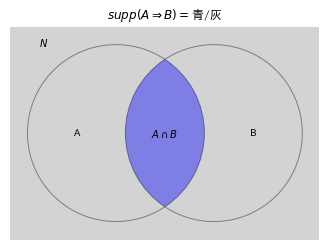

In [3]:
from helpers.market_basket_analysis import support
support.show()

*教科書などでのアソシエーションルールの表現としては一般に $\displaystyle supp( A\cup B) =\sigma ( A\cup B)$ で積集合 ( $A$ かつ $B$ ) を表すが、一般的な集合の表記と比較して紛らわしいので、ここでは $\displaystyle \sigma ( A\cap B)$ と表す。*

### 信頼度 (confidence)
---
条件が発生した場合の結論の起こる確率。低いと**重要なルール**ではない。

$
\begin{align}
    conf( A\Rightarrow B) & =\frac
        {supp( A\Rightarrow B)}
        {supp( A)}\\
     \\
     & =\frac
         {\sigma ( A\cap B)}
         {\sigma ( A)}\\
     \\
     & =p( B|A)
\end{align}
$

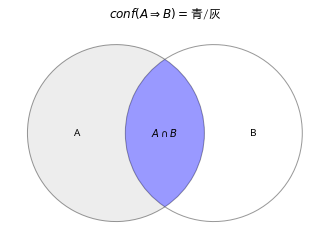

In [4]:
from helpers.market_basket_analysis import confidence
confidence.show()

### リフト値 (lift)
---
条件部によって結論部の確率が引き上げられた (引き下げられた) 倍率。1より高いほど**条件の効果**がある。

$
\begin{align}
    lift( A\Rightarrow B) & =\frac
        {conf( A\Rightarrow B)}
        {supp( B)}\\
     \\
     & =\frac
         {p( B|A)}
         {p( B)}\\
     \\
     & =\frac
         {p( A,B)}
         {p( A) \ p( B)}
\end{align}
$

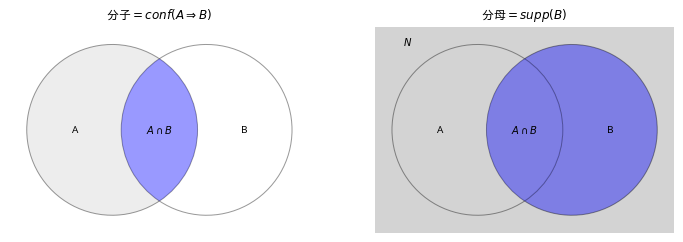

In [5]:
from helpers.market_basket_analysis import lift
lift.show()

*ベイズの枠組みで考えると $
\displaystyle lift( A\Rightarrow B)=\frac
    {事後確率}
    {事前確率}
$ と捉えられる。*

## Aprioriアルゴリズム
---
全アイテム数を $n$ とすると、条件部・結論部それぞれのアイテム数が1ずつの組み合わせでも $n(n-1)$ 通りがあり、アイテム数が増えるにつれて全ての組み合わせを計算することはできなくなる。そこで、条件部単独の支持度が低い (あまり発生しない) ものについてはそれ以上計算しないことにして、計算量を減らすのがAprioriアルゴリズム。

## Pythonでの実行方法
---
`mlxtend.frequent_patterns.apriori`を用いる。

In [6]:
apriori??

In [7]:
association_rules??

マーケット・バスケット分析では、トランザクションデータを対象にするが、実際に分析する際には以下のようにカラム (列) に全商品のリストをとり、その商品がサンプル (行) に含まれるかどうかの真偽値を要素に持つ表データに加工する。

In [8]:
Groceries = pd.read_csv('data/Groceries.csv')
print('変数Groceriesの中身')
display(Groceries)

変数Groceriesの中身


,frankfurter,sausage,liver loaf,ham,meat,...,pot plants,flower soil/fertilizer,flower (seeds),shopping bags,bags
0,False,False,False,False,False,...,False,False,False,False,False
1,False,False,False,False,False,...,False,False,False,False,False
2,False,False,False,False,False,...,False,False,False,False,False
3,False,False,False,False,False,...,False,False,False,False,False
4,False,False,False,False,False,...,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9830,False,True,False,False,False,...,False,False,False,False,False
9831,False,False,False,False,False,...,False,False,False,False,False
9832,False,False,False,False,False,...,False,False,False,False,False
9833,False,False,False,False,False,...,False,False,False,False,False


以下が、実際に実行した結果。

In [9]:
frequent_itemsets = apriori(Groceries, min_support=0.01, use_colnames=True)
arules = association_rules(
    frequent_itemsets, metric='confidence', min_threshold=0.5)
arules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(root vegetables, citrus fruit)",(other vegetables),0.017692,0.193493,0.010371,0.586207,3.029608,0.006948,1.949059
1,"(tropical fruit, root vegetables)",(other vegetables),0.021047,0.193493,0.012303,0.584541,3.020999,0.008231,1.941244
2,"(tropical fruit, root vegetables)",(whole milk),0.021047,0.255516,0.011998,0.570048,2.230969,0.006620,1.731553
3,"(yogurt, tropical fruit)",(whole milk),0.029283,0.255516,0.015150,0.517361,2.024770,0.007668,1.542528
4,"(pip fruit, other vegetables)",(whole milk),0.026131,0.255516,0.013523,0.517510,2.025351,0.006846,1.543003
...,...,...,...,...,...,...,...,...,...
10,"(yogurt, other vegetables)",(whole milk),0.043416,0.255516,0.022267,0.512881,2.007235,0.011174,1.528340
11,"(other vegetables, whipped/sour cream)",(whole milk),0.028876,0.255516,0.014642,0.507042,1.984385,0.007263,1.510239
12,"(other vegetables, domestic eggs)",(whole milk),0.022267,0.255516,0.012303,0.552511,2.162336,0.006613,1.663694
13,"(yogurt, curd)",(whole milk),0.017285,0.255516,0.010066,0.582353,2.279125,0.005649,1.782567


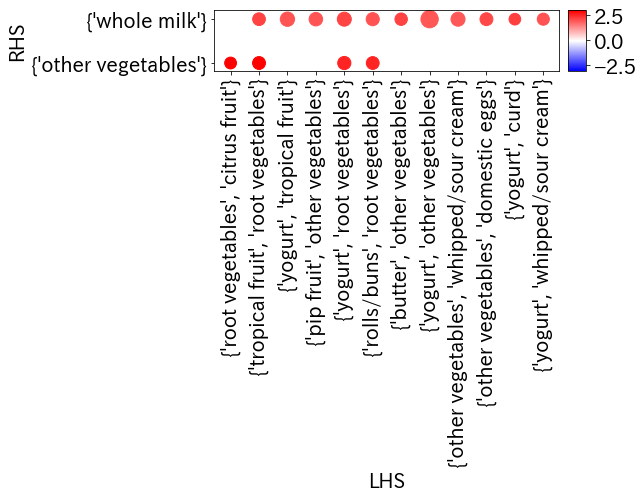

In [10]:
from helpers.market_basket_analysis.association_rules_viz import matrix
matrix(
    'antecedents',
    'consequents',
    size='support',
    color='lift',
    data=arules,
    cmap='bwr',
    font_size=20)

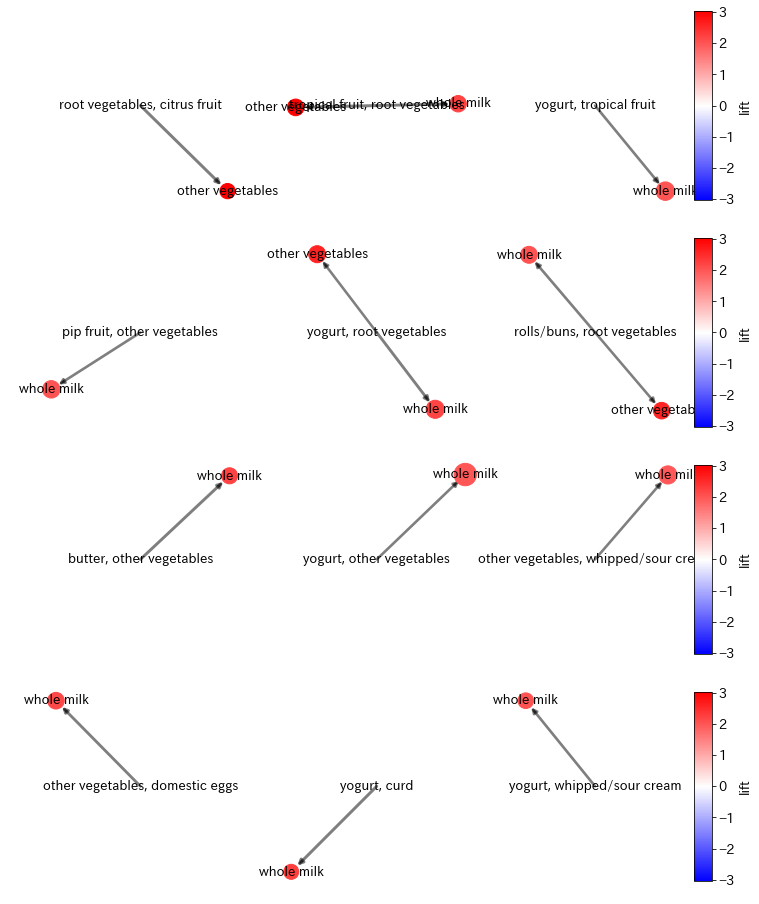

In [11]:
from helpers.market_basket_analysis.association_rules_viz import graph
graph(
    'antecedents',
    'consequents',
    support='support',
    confidence='confidence',
    lift='lift',
    data=arules,
    fig_scale=4,
    font_size=13,
    cmap='bwr')

###### 練習問題

`apriori`の`min_support`を変更して、扱いやすい (実行時間が長くなりすぎない) サイズのルールを抽出したり、`association_rules`の引数を変更して重要そうなルールの候補を選んでみる。